In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
connection = engine.connect()

# Exploratory Climate Analysis

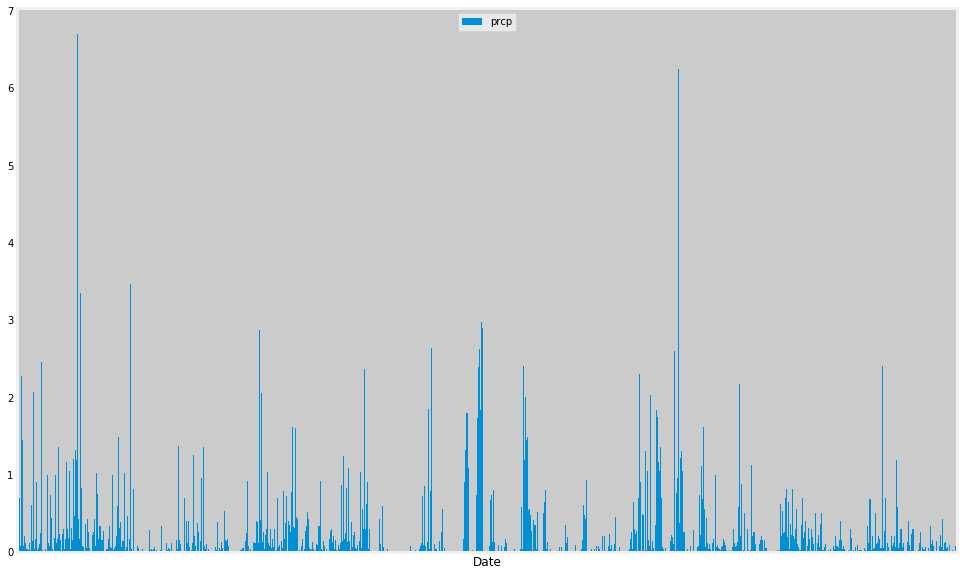

In [121]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
year_ago = datetime.strptime(last_date, '%Y-%m-%d') - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago.strftime("%Y-%m-%d"))

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame(prcp_query)
measure_df.set_index(['date'], inplace=True)

# # Sort the dataframe by date
measure_df.sort_values('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax = measure_df.plot(kind='bar', figsize=(15,10), label='Precipitation', legend=True, width=2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.set_xlabel('Date', fontsize=12)
plt.grid(linestyle='-', linewidth=2)
ax.legend(loc="upper center")
plt.show()

![precipitation](Images/precipitation.png)

In [64]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [101]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.name)).first()
stations

(9)

In [89]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station, func.count(Measurement.station).label("Count")).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for result in station_query:
    print(f"{result.station} \t {result.Count}")


USC00519281 	 2772
USC00519397 	 2724
USC00513117 	 2709
USC00519523 	 2669
USC00516128 	 2612
USC00514830 	 2202
USC00511918 	 1979
USC00517948 	 1372
USC00518838 	 511


In [96]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_station = station_query[0][0]

station_stats = session.query(func.min(Measurement.tobs).label("MinTemp"), func.max(Measurement.tobs).label("MaxTemp"), func.avg(Measurement.tobs).label("AvgTemp")).\
    filter(Measurement.station == max_station).all()
print(station_stats)


[(54.0, 85.0, 71.66378066378067)]


Text(0, 0.5, 'Frequency')

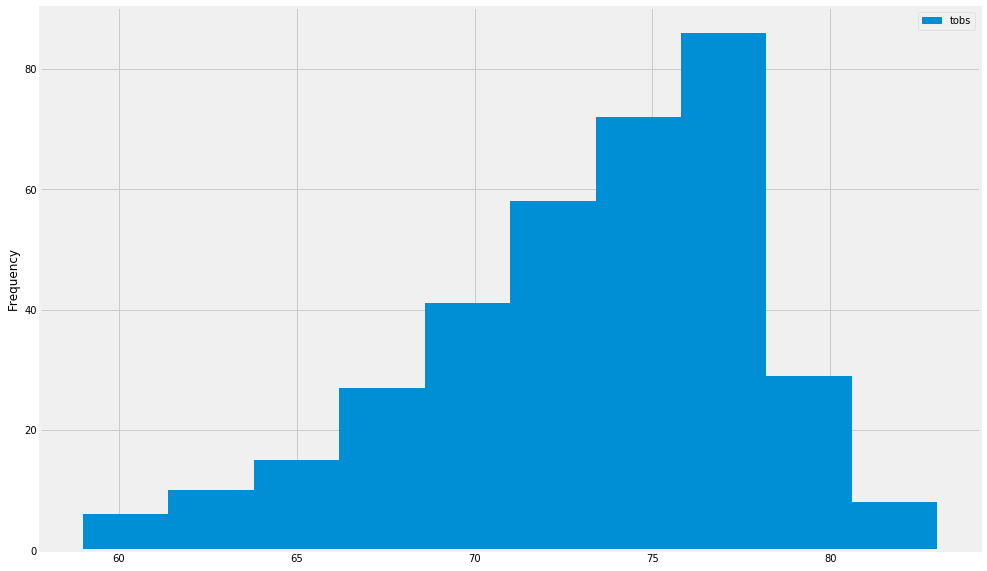

In [143]:
# Choose the station with the highest number of temperature observations.
tmp_reading_cnt = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

tmp_reading_cnt[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == max_station).\
    filter(Measurement.date >= year_ago.strftime("%Y-%m-%d")).order_by(Measurement.date).all()

temp_df = pd.DataFrame(tobs_query)

plt.figure(figsize=(15,10))
plt.hist(temp_df['tobs'], label='tobs')
plt.legend()
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [125]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [126]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2017-07-01', '2017-07-10')[0]
trip_temps

(69.0, 78.15254237288136, 87.0)

Text(0.5, 1.0, 'Trip Avg Temp')

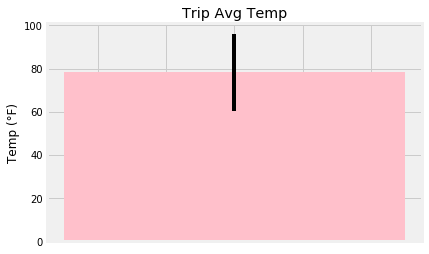

In [127]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = trip_temps[2] -trip_temps[0]
plt.bar(x=0,height=trip_temps[1], width=1, yerr=error, color='pink')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Temp (°F)')
plt.title('Trip Avg Temp')

In [158]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_query = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude,
                              Station.elevation).join(Station, Station.station == Measurement.station).\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
    filter(Measurement.date.between('2017-07-01', '2017-07-10')).all()
print(rainfall_query)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 1.36, 21.3331, -157.8025, 152.4), ('USC00519281', 'WAIHEE 837.5, HI US', 0.77, 21.45167, -157.84888999999998, 32.9), ('USC00513117', 'KANEOHE 838.1, HI US', 0.4, 21.4234, -157.8015, 14.6), ('USC00519397', 'WAIKIKI 717.2, HI US', 0.12, 21.2716, -157.8168, 3.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.06, 21.5213, -157.8374, 7.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.02, 21.33556, -157.71139, 19.5), ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [62]:
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [ ]:
measure_df = pd.read_sql(f"SELECT date, prcp AS Precipitation FROM measurement WHERE date >= '{year_ago}'", connection)
measure_df

In [124]:
temp_df.tail()

,tobs
date,
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0
2017-08-17,76.0
2017-08-18,79.0


In [ ]:
measure_df.describe()
